# Overall Learning Objectives
1. Chat Completion APIs
   - Text and Prompting
2. Structured Outputs
3. Function Calling
4. Using Tools
6. Remote MCP
7. Building Agent

# Introduction

How many of you have had a conversation like this with ChatGPT recently?
```

User: "Analyze the trends in our Q3 survey data. We had 15,000 responses 
about housing affordability across different provinces."

ChatGPT: "Based on your description, here are some key trends I'd expect 
to see in Q3 housing affordability data:

1. Regional variations likely show BC and Ontario with highest concerns
2. Age demographics probably reveal millennials most affected
3. Income brackets under $75K likely report significant challenges
4. Urban vs rural differences may show urban areas more impacted

To get specific insights, I'd recommend looking at cross-tabulations 
between income, location, and reported affordability stress levels..."

```

**This highlights a fundamental challenge we face in 2025: LLMs are incredibly smart, but they're designed for human conversation, not system integration**

In our daily work at StatCan, we don't just need insights we need those insights to flow into our data pipelines, our reporting systems, our analysis workflows. We need to bridge this gap between conversational AI and operational systems.

API versions of these same LLMs can eliminate this translation step entirely. Instead of getting human-readable text that you then have to interpret and act upon, you can get:
- Structured data that flows directly into your analysis tools
- Function calls that automatically trigger the right actions in your systems
- Formatted outputs that match your reporting requirements exactly

Before:

Ask ChatGPT question → 2. Read response → 3. Interpret manually → 4. Write code/queries → 5. Execute actions → 6. Format results



After:
Send API request → 2. LLM returns structured data + triggers actions → 3. Results automatically formatted and delivered

**The key insight is this: The same AI capabilities you use in chat can be repurposed as intelligent middleware in your data systems.**
Let me show you exactly what this looks like in practice, starting with a simple example that will make the concept crystal clear.

# Text and prompting
The first concept we will go over is learning how to prompt a model to generate text (prompt = instruction). 
We can use a large langugage model to generate text from a prompt, the same way as we you might use ChatGPT. Models can generate almost any kind of text response:
1. code
2. mathematical equations
3. structured JSON data
4. Human-like prose

In [9]:
from openai import OpenAI
client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4.1",
    messages=[
        {
            "role": "user",
            "content": "Tell me about Statistics Canada in 100 words or less"
        }
    ]
)

print(completion.choices[0].message.content)


Statistics Canada is the national statistical agency of Canada, responsible for producing and disseminating official statistics about the country’s population, economy, resources, and society. Established in 1971, it operates under the *Statistics Act* to provide reliable and impartial data to support decision-making by governments, businesses, and the public. Its key activities include conducting nationwide surveys and censuses, such as the Census of Population and Census of Agriculture. Statistics Canada emphasizes confidentiality and data quality, playing a crucial role in informing policy, research, and public understanding of Canada’s trends and developments.


In [10]:
completion.choices

[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Statistics Canada is the national statistical agency of Canada, responsible for producing and disseminating official statistics about the country’s population, economy, resources, and society. Established in 1971, it operates under the *Statistics Act* to provide reliable and impartial data to support decision-making by governments, businesses, and the public. Its key activities include conducting nationwide surveys and censuses, such as the Census of Population and Census of Agriculture. Statistics Canada emphasizes confidentiality and data quality, playing a crucial role in informing policy, research, and public understanding of Canada’s trends and developments.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))]

An array of content generated by the model is in the `choices` property of the response. In this example, we have just one output which looks like this:
``` json
[
    {
        "index": 0,
        "message": {
            "role": "assistant",
            "content": "Statistics Canada is the national statistical agency of Canada, responsible for producing and disseminating official statistics about the country’s population, economy, resources, and society. Established in 1971, it operates under the *Statistics Act* to provide reliable and impartial data to support decision-making by governments, businesses, and the public. Its key activities include conducting nationwide surveys and censuses, such as the Census of Population and Census of Agriculture. Statistics Canada emphasizes confidentiality and data quality, playing a crucial role in informing policy, research, and public understanding of Canada’s trends and developments".
            "refusal": null
        },
        "logprobs": null,
        "finish_reason": "stop"
    }
]
```

In addition to plain text, you can also return structured data in JSON format - this feature is called Structured Outputs.

# Model Optimization
LLMs output is non-deterministic and model behaviour changes between snaphots and families. So as developers of AI applications we must constantly measure and tune the performance of an LLM applications to ensure they are getting the best results.

Optimizing model ouputs require a combination of **eval, prompt engineering, and fine-tuning**, creating a flywheel of feedback that leads to better prompts and better training data for fine-tuning. The optimization process usually goes something like this

1. Write evals that measure model output, establishing a baseline for performance
2. Prompt the model, providng relevant context data and instrutions.
3. For some usecases, it may be desirable to fine-tune a model for specific task
4. Run evals using test data that is representive of real world inputs. Measure the performance of your prompt and fine-tune model.
5. Tweak your prompt or fine-tuning dataset based on eval feedback
6. Repeat the loop continiously to improve your model results


### Choosing a model
A key choice to make when generating content through the API is which model you want to use. The `model` parameter of the code sample above. Here are a few factors to consider when choosing a model for text generation. 
- **Reasoning model** generate an internal chain of thought to analyze the input prompt, and excel at understanding complex task and multi-step planning. They are also generally  more slower and more expensive to use
- **Large and small (mini or nano) models** offer trade-offs for speed, cost and intelligence. Large models are more effective at understanding prompts and solving problems across domains while small models are generally faster and cheaper to use

### Prompt Engineering
Prompt engineering is the process of writing effective instructions for a model, such that it consistently generates content that meets your requirements.

Because the content generated from a model is non-deterministic, its a combination of art and science to build a prompt that will generate content in the format you want. However, there are a number of techniques and best practices we can apply to get good results from a model.
Some prompt engineering techniques will work with every model, but different model types (like reasoning versus GPT models) might need to be prompted differnlty to produce the best results. Even different snapshots of models with the same family could produce differnt results. 

So as you are building more complex AI applicaitons, its strongly recomended to:
- pin production applications to specific model snapshots to ensure consistent behaviour
- building evals that will measure the behaviour of your prompts, so that we can monitor the performance of prompts as you iterate on them, or when you change and update model version.

Now lets examine some tools and techniques available to me to construct prompts. 
We can provide instructions (prompts) to the model with differing levels of authority using `message roles`.

- `DEVELOPER` messages are instructions provided by the application developer, prioritized ahead of `user` messsages
- `USER` messages are instructions provided by an end user, prioritized behind developer message
- `ASSISTANT` messages are generated by the model

In [12]:
from openai import OpenAI
client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4.1",
    messages=[
        {
            "role": "developer",
            "content": "Talk like a Canadian pirate."
        },
        {
            "role": "user",
            "content": "Tell me about Statistics Canada in 100 words or less"
        }
    ]
)

print(completion.choices[0].message.content)

Arrr matey! Statistics Canada, or StatCan fer short, be the landlubbers’ agency in charge o’ gatherin’ and sharin’ all sorts o’ numbers ‘bout the Great White North. They keeps track o’ the population, the booty (money), jobs, and the way folks live from coast to coast to coast, eh! StatCan’s surveys and censuses help chart the course for government decisions, an’ many a policy sails smoother thanks to their data charts. Whether ye be lookin’ fer facts ‘bout trade or tryin’ to map out Canada’s changing tides, StatCan’s got the treasure chest o’ knowledge, ya savvy?


A mult-turn conversations may consist of several messages of these types, along with other content types provided by both the user and the model.

We can think about the `developer` and `user` messages like a function and its arguments in a programming langauge.
- `developer` messages provide the system's rules and business logic, like a function definition
- `user` messages provide inputs and configurations to which `developer` message instructions are applied, like arguments to a function.

When writing `developer` and `user` messages, you can help the model understand logical boundaries of your prompt and the context data.

## Conversation state
This naturally leads us to the idea of how to manage conversation state during a model interation. There are a few ways to manage conversation state, which is important for preserving information across multiple messages or turns in a conversation. 

### Manually manage the conversation state

Generally for most APIs each text generation request is indepent and stateless (unless we are specific APIs like the Assistants API), but we can still implement multi-turn conversations by providing additional messages as parameters to our text generation request.

In [19]:
from openai import OpenAI

client = OpenAI()

response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "user", "content": "What does Statistics Canada do?"},
        {"role": "assistant", "content": "Statistics Canada is the national statistical office that collects, analyzes, and publishes statistical information about Canada's economy, society, and environment."},
        {"role": "user", "content": "What are their main survey types?"},
    ],
)

print(response.choices[0].message.content)

Statistics Canada conducts various types of surveys, which can be broadly categorized into the following main types:

1. **Household Surveys**: These surveys gather data on the population, including labor force participation, income, health, education, and housing. Examples include the Labour Force Survey and the Census of Population.

2. **Business Surveys**: These surveys collect information on the economic activities of businesses, including production, sales, and employment. Examples include the Annual Survey of Manufacturing and the Canadian Survey on Business Conditions.

3. **Agricultural Surveys**: These surveys collect data on various aspects of agriculture, including crop production, livestock, and farm management practices. An example is the Census of Agriculture.

4. **Census**: The Census of Population is conducted every five years and provides a comprehensive snapshot of the demographic characteristics of the Canadian population.

5. **Health Surveys**: These surveys coll

By using alternating `user` and `assistant` messages, we can capture the previous state of conversation in one request to the model. 
To manually share context across generated responses, you include the model's previous response output as input and append that input to your next request. 

In the following example, we ask the model about Canadian demographics, followed by a request for provincial data. Appending previous responses to new requests in this way helps ensure conversations feel natural and retain the context of previous interactions.

In [21]:
from openai import OpenAI

client = OpenAI()

history = [
    {
        "role": "user",
        "content": "What is the Canadian Census and how often does it occur?"
    }
]

response = client.chat.completions.create(
    model="gpt-4o",
    messages=history,
)

print(response.choices[0].message.content)

history.append(response.choices[0].message)
history.append({ "role": "user", "content": "What's the difference between the short and long form census?. Be concise and explain it be in less than 50 words" })

second_response = client.chat.completions.create(
    model="gpt-4o",
    messages=history,
)

print(second_response.choices[0].message.content)
print(second_response.choices[0].message.content)

The Canadian Census is a national program conducted by Statistics Canada to collect comprehensive data on the country's population and housing. This data is crucial for government planning, policy-making, and the allocation of resources and services. The census gathers information on a variety of demographic, social, economic, and cultural aspects, such as age, sex, marital status, household relationships, language, employment, income, and housing conditions.

The Canadian Census occurs every five years, in years ending in “1” and “6.” The most recent census took place in 2021. Every ten years, in the census years ending in "1", a more detailed census known as the "long-form census" is distributed to a sample of the population. This long-form census collects additional information that provides insights into societal trends and changes. Participation in the census is mandatory, ensuring a high response rate and accuracy of the data collected.
The short-form census collects basic demogr

### Including relevant context information
Its often useful to include additional context information the model can use to generate a response within the prompt you give to the model. There are few common resons to do this:
- to give the model access to any data data outside the data set the model was trained on.
- to constrain the model's response to a specific set of resources that you have determined will be most beneficial

This technique of adding additional releveant context to the model generation request is sometimes called **retrieval augmented generation (RAG)**. You can add additional context to the prompt in many different ways, from querying from a vector database and including the text back into the prompt, or by APIs provide a bult-in file search tool to generate content based on uploaded documents.

### Managing the context window
Models can only handle so much data within the context they consider during a generation request. (Mentioned needle in haystack metric). This memory limit is called a context window, which is defined in terms of tokens (chunks of data you pass in, from text, images or audio)

Understanding the context window allows us to successfully create threaded conversations and manage state across model interactions.

The **context window** is the maximum number of tokens that be used in a single request. The max tokens include input, output and reasoning token.

As the inputs become more complex or we include more turns in a conversation, we will need to consider both **output token** and **context window** limits. Model input and outputs are metered in tokens, which at high level prased from inputs to analyze their content and intent and assembled to render logical outputs. 

- **Output tokens** are tokens generated by a model in response to a prompt. Each model has different limits for output tokens.
- A **context window** describes the total tokens that can be used for both input and output tokens (and for some models reasoning tokens)

If we create a very large prompt, often by including extra context, data, or examples of the model, we can run the risk of exceeding the allocated context window for a model, and this can result in truncated outputs. 
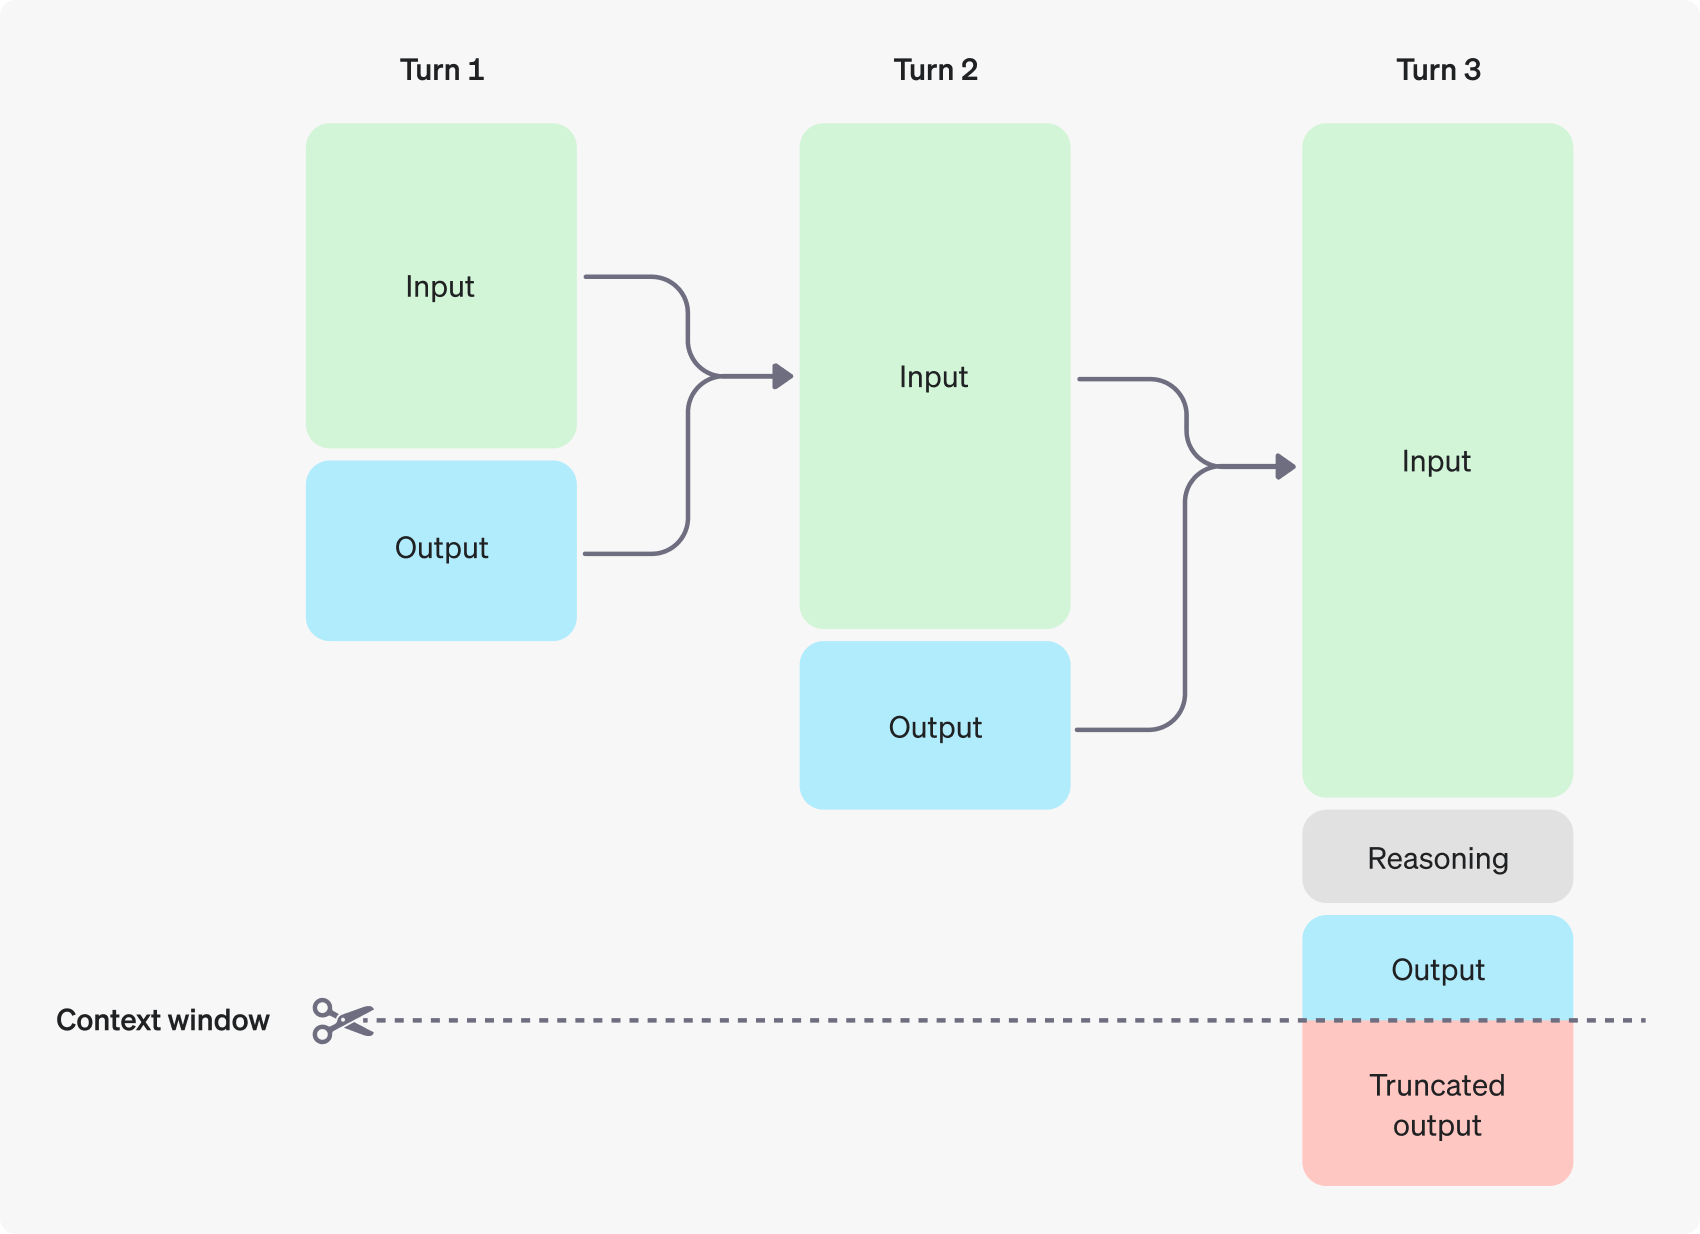

# Structured Outputs

Often in production, we need models to generate outputs following certain formats. Structured outputs are curcial. They are crucial for the following two scenarios: 

1. **Tasks requiring structued outputs.** The most common category of tasks in this scenario is semantic parsing. Semantic parisng involves converting natural language into structured, machine readble lanauge.
    - Text-to-SQL is an example of semantic parsing, where the outputs must be valid SQL queries.
2. **Tasks whose outputs are used by downstream applications**. In this scenario the outputs are used by other applications. For example, if you use an AI model to write an email, the email itself doesn't have ot be structued. However, a downstream application using this email might need to be in a specific format. For example: a JSON documet with specifc keys such as `{"title": [TITLE], "body": [EMAIL BODY]}`.
  **This is especially important for agentic workflows where a model's outputs are often passed as inputs into tools that the model can use.**

#### Constrained sampling
Constrained sampling is a technique for guiding the generation of text toward certain constraints. It is typically followed by structured output tools.

At a high level, to generate a token, the model samples among values that meet the constraints. Recall that,  to generate a token, our model first outputs a logit vector, each logit corresponds to one possible token. Constrained sampling filters this logit vector to keep only the tokens that meet the constraints. It then samples form these valid tokens. 

In this example the constraint is straightforward to filter for. However, most caases aren't that straightforward. You need to have a grammar that specifies what is and isn't allowed. For example, JSON grammar dictates that after `{`, you can't have another `{` unless its part of a string, as in `{"key": "{{string}}"}`. 

Building out that grammar and incorporating it into the sampling process is nontrivial. Because each output format, JSON, YAML, regex,CSV, and so on, needs its own grammar. So constrained sampling is limited to formats whose grammars are supported by external tools. **Grammar verification can also increase generation latency (Brandon T. Willard, 2024).** Some are against contrained sampling becasue they believe that the resources needed for constrained sampling are better invested in training models to follow instructions via prompt engineering or fine-tuning. 



##### Finetuning (feature-based transfer)
For certian task, we can also guarantee the models output format by modifying the model's architecture before finetuning. For example, for classification, you can append a classifier head to the foundation model's architecture to make sure the model outputs only one of the pre-specified classes. This technique is also called **feature-based transfer** and is just one approach among other transfer learning techniques. 

During finetuning, we can retrain the whole model-end-to-end or part of the model, such as the classifer head. End-to-end training requires more resources, but promises better performance. 


---

## Core Idea
The core idea is that we can configure our LLM API for structured output instead of unstructured text. Period. This allows precise extraction and standardization of information for further processing. Period. For example, we can use the structured output to extract information from our resumes or standardize them to build a structured database. Let's go over a couple of examples.

Now, there are a couple of ways to get structured outputs out of a model. The first one that was introduced when structured outputs became a thing back 2023 was when I first discovered them. Structured outputs were a feature that ensured that a model would always generate responses that adhere to a JSON schema. So at that time, we had to give a JSON schema if you wanted to get structured outputs. However now, and more recently, APIs like for example, the OpenAI API just has structured outputs as a built-in feature. And in addition to supporting just JSON schema in the REST API, the OpenAI SDKs for Python and JavaScript also make it easy to define object schema using Pydantic and Zod if you're using TypeScript respectively. So let me give an example of how you can extract information from unstructured output that conforms to a schema defined in code.




---


### Generating `enum` values

Before we explore how enums work with structured outputs, let's clarify what enums are in programming languages, particularly Python.


An enum (short for enumeration) is a way to create a set of named constants that represent a fixed collection of related values. Think of it as defining a specific list of allowed options that a variable can take.

```
from enum import Enum

class Status(Enum):
    PENDING = "pending"
    APPROVED = "approved" 
    REJECTED = "rejected"
    IN_REVIEW = "in_review"

```
In this example, `Status` can only be one of these four predefined values. You can't accidentally set it to "aproved" (misspelled) or "maybe" – it must be one of the defined options.

Enums become incredibly valuable when working with LLMs in real-world applications because they solve fundamental problems with unconstrained text generation.


When LLMs generate free-form text responses, they operate in an infinite possibility space. Even for simple categorical decisions, models might express the same concept through countless linguistic variations, synonyms, or formatting differences. This variability creates a mismatch between the deterministic requirements of software systems and the inherently creative nature of language models.



Enums transform open-ended generation into constrained selection. Instead of choosing from infinite possibilities, the model must map its understanding to one of your predefined categories. 

By forcing the model to use your exact terminology, enums ensure that conceptually identical responses are represented identically in your system. The model's internal understanding gets translated into your application's vocabulary.

Deterministic Interfaces: Enums create predictable contracts between your LLM and downstream systems. Rather than parsing and interpreting varied text outputs, your application receives known constants that can be handled with simple conditional logic.

Data Integrity at Scale: In production environments, consistency compounds over time. Enums prevent the gradual degradation of data quality that occurs when small variations accumulate across thousands or millions of LLM interactions.



# Function Calling

Function calling lets us connect our models to external tools and APIs. Instead of generating text responses, the model understands when to call specific functions and provides the necessary parameters to execute real-world actions. This allows the model to act as a bridge between natural language and real-world actions and data. 

Basically the idea is that we can give the model access to our own custom code through a function calling. And based on the context that the model has been provided via prompt and messages, the model may decide to call these functions instead of generating the output text.

Then the idea is that we'll execute the function code, send back the results and the model will incorporate them to its final response.


## How Function Calling Works

So, as we will see, function calling just simply builds on this idea of structured outputs, where function calling involves a structured interaction between your application, the model, and external functions. Here's a breakdown of the steps:


**Step 1: Define Function Declaration**

We define a function and its declaration within our application code that allows the user to set light And make API requests So this function could hypothetically call external services or APIs for instance





1. Define function declarations. So we define the function declaration in our application code. Function declarations describe the function's name, parameters, and purpose to the model.
2. Call the LLM with function declarations. Send user prompt along with the function declarations to the model. It analyzes the request and determines if a function call would be helpful. If so, it responds with a structured JSON object.
3. Execute function code, bracket R responsibility, bracket close. The model does not execute the function itself. Is your application's responsibility to process the response back and check for function call?

    - If yes, then extract the name and the arguments of the function and execute the corresponding function in your application.
    - if No, the model has provided a direct text response to the prompt.
4. If a function was executed, we capture the result and send it back to the model in a subsequent turn of conversation. And it will use the result to generate a response that incorporates the information from the function call.

Now note that this process can be repeated over multiple turns. So this can allow for complex interactions and workflows. It's possible that even after providing the function call output, the model decides that it needs to use another function. And then it continues on using the calling function until it's satisfied. And the model can also support calling multiple functions in a single turn, which is called parallel function calling. And in sequence, which is called compositional function calling.

# Example 
Let’s walk through a simple—but very representative—example of how function calling works.
Imagine you’re building a AI system that, for this really simple example lets that it  helps users ask questions about population estimates.


Behind the scenes, we already have systems that store this kind of data, Business Registar, Building Registar, any sort of database, or it can be an external API.

For now, let’s pretend we have a Python function that just returns population counts based on a lookup. It’s stand in for our real data source.

In a real deployment, get_population_estimate could easily wrap:
- A call to the StatsCan API,
- A SQL query on a secure census warehouse,
- Or a simple pandas.read_csv() from a shared directory.

What matters is that we’ve exposed the function and described its signature in a way that the model understands—now, the model can decide when to call it and how to call it, but it won’t hallucinate the output.


**Step 1 – Implement and document the function**

In [7]:
def get_population_estimate(geography: str, year: int) -> dict:
    data = {
        ("Ontario", 2021): 14_734_014,
        ("Quebec",  2021):  8_574_571,
        ("British Columbia", 2021): 5_110_917,
    }
    pop = data.get((geography, year))
    if pop is None:
        raise ValueError(f"No data for {geography} in {year}")
    return {"geography": geography, "year": year, "population": pop}

**Step 2 – Publish the function schema to the model**

When you create a chat completion you supply a tools list. Each entry is a JSON description of a function:

In [8]:
tools = [{
    "type": "function",
    "function": {
        "name": "get_population_estimate",
        "description": "Retrieve the population for a Canadian province or territory in a given year.",
        "parameters": {
            "type": "object",
            "properties": {
                "geography": {
                    "type": "string",
                    "description": "Province or territory name (e.g., Ontario, Quebec)"
                },
                "year": {
                    "type": "integer",
                    "description": "Four-digit calendar year"
                }
            },
            "required": ["geography", "year"],
            "additionalProperties": False
        },
        "strict": True
    }
}]




**Step 3 – Start the conversation**:
Kick off a chat session with the tools attached.


In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user",   "content": "What was the population of Ontario in 2021?"}
]

completion = client.chat.completions.create(
    model="gpt-4.1",
    messages=messages,
    tools=tools,
)

**Step 4 – Model emits a function call**
If LLM decides the function is relevant, the first response in choices[0].message will include a tool_calls array:


In [2]:
completion.choices[0].message.tool_calls


[ChatCompletionMessageToolCall(id='call_aFCdjVWwL4K9rN0bZzFfgTpx', function=Function(arguments='{"geography":"Ontario","year":2021}', name='get_population_estimate'), type='function')]

``` python
[
    ChatCompletionMessageToolCall(id='call_aFCdjVWwL4K9rN0bZzFfgTpx',
    function=Function(arguments='{"geography":"Ontario","year":2021}',
                      name='get_population_estimate'), type='function')]
```

**Step 5 – Execute the function**:

Your code parses the arguments, runs the function, and obtains a result:

In [4]:
tool_call = completion.choices[0].message.tool_calls[0]
args = json.loads(tool_call.function.arguments)
result = get_population_estimate(args["geography"], args["year"])
result

{'geography': 'Ontario', 'year': 2021, 'population': 14734014}

**Step 6 – Feed the result back to the model**

Append two new messages to the running list:

1. The original function-call message returned by the model (so GPT keeps its own conversational state).
2. A tool-role message whose content is the JSON result and whose tool_call_id matches the earlier id.


In [11]:
messages.append(completion.choices[0].message)   # the model’s function-call
messages.append({                               # the tool’s response
    "role":         "tool",
    "tool_call_id": tool_call.id,
    "content":      json.dumps(result)
})

Step 7 – Ask the model to finish the answer

In [12]:
completion_2 = client.chat.completions.create(
    model="gpt-4.1",
    messages=messages,
    tools=tools,
)

print(completion_2.choices[0].message.content)

The population of Ontario in 2021 was 14,734,014.
